# Trabalho 02 Unidade 01

In [ ]:
!pip install nxviz==0.6.3

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import nxviz

## 1. Dataset:
[This](https://github.com/alvarofpp/dataset-flights-brazil) repository have datasets with all flights in Brazil registered by ANAC (Agência Nacional de Aviação Civil - National Civil Aviation Agency), all airports involved in these flights and a undirected graph with the number of flights between two airports.

Creating the graph:


In [3]:
"""
Creates an undirected graph (air_traffic.graphml)
Code from alvarofpp/dataset-flights-brazil repository
"""

df_airports = pd.read_csv('data/airports.csv')
df_flights = pd.read_csv('data/anac.zip')

# Create graph
Gr = nx.Graph()

# Add nodes
for index, row in df_airports.iterrows():
    Gr.add_node(row['code'],
               name=row['name'],
               country=row['country'],
               latitude=row['lat_geo_point'],
               longitude=row['lon_geo_point'],
               region=row['region']
               )

# Add edges
df_edges = df_flights[[
    'origin_airport_abbreviation',
    'destination_airport_abbreviation',
]].dropna()

df_edges = df_edges.groupby(df_edges.columns.tolist(), as_index=False).size()

for index, row in df_edges.iterrows():
    if row['origin_airport_abbreviation'] == row['destination_airport_abbreviation']:
        continue
    Gr.add_edge(row['origin_airport_abbreviation'], row['destination_airport_abbreviation'], flight_count=row['size'])

# Export to graphml
nx.write_graphml(Gr, 'data/air_traffic.graphml')

`air_traffic` it's an undirected graph. Reading the graph in GraphML format:

In [4]:
G = nx.read_graphml('data/air_traffic.graphml')

Showing the number of nodes and the number of edges of the graph:

In [5]:
print(G.number_of_nodes())
print(G.number_of_edges())

1083
9613


Different from the original graph of the repository 'alvarofpp/dataset-flights-brazil', this graph has the attribute "region" on the nodes.

Showing attributes of the node 'SBGR':

In [6]:
G.nodes['SBGR']

{'name': 'GUARULHOS',
 'country': 'BRASIL',
 'latitude': '-23.435556411743164',
 'longitude': '-46.47305679321289',
 'region': 'SUDESTE'}

Showing the numbers of components of the graph:

In [7]:
for component in list(nx.connected_components(G)):
    print(len(component))

1080
1
2


Showing a representation of the component with 1080 nodes:

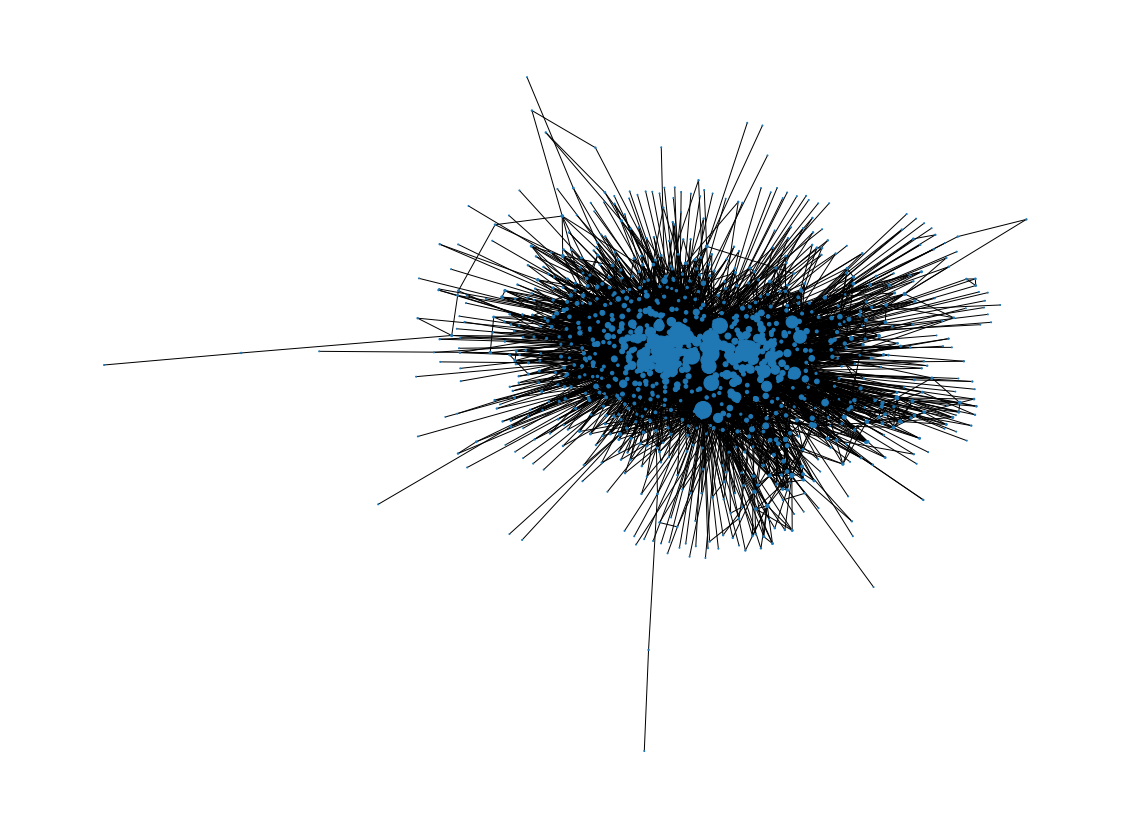

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
subgraph = nx.subgraph(G, list(nx.connected_components(G))[0])
nx.draw_networkx(subgraph, pos=nx.spring_layout(subgraph),
                 node_size=[value for key, value in nx.degree(subgraph)],
                 ax = ax,with_labels=False)
ax.axis("off")
plt.savefig("images/graph.png")
plt.show()

## Questões

**● Realizar um estudo sobre a assortatividade da rede considerando como atributo a REGIÃO onde está localizado o aeroporto.**

**● Gerar um gráfico similar considerando como grupo a REGIÃO do aeroporto.** 

Creating a subgraph with airports in Brazil:

In [9]:
SG = G.subgraph([n for n,attrdict in G.nodes.items() if attrdict['country'] == 'BRASIL'])
print('number of nodes: ' + str(len(SG)))

number of nodes: 495


In [10]:
nx.attribute_assortativity_coefficient(SG,"region")

0.36728130173582757

Assortativity is a preference for a network's nodes to attach to others that are similar in some way. 

In general, the assortativity coefficient lies between −1 and 1. When assortativity coefficient = 1, the network is said to have perfect assortative mixing patterns, when assortativity coefficient = 0 the network is non-assortative, while at assortativity coefficient = −1 the network is completely disassortative.

In this case, this network has assortativity of 0.37. 

In [11]:
nx.attribute_mixing_matrix(SG,'region')

array([[0.17446615, 0.03441617, 0.02782826, 0.04009541, 0.05599727],
       [0.03441617, 0.05224898, 0.02226261, 0.01226715, 0.01067697],
       [0.02782826, 0.02226261, 0.13584734, 0.00726942, 0.02078601],
       [0.04009541, 0.01226715, 0.00726942, 0.06905952, 0.01317583],
       [0.05599727, 0.01067697, 0.02078601, 0.01317583, 0.07882781]])

Generating a CircosPlot considering the airports regions as a grouping:

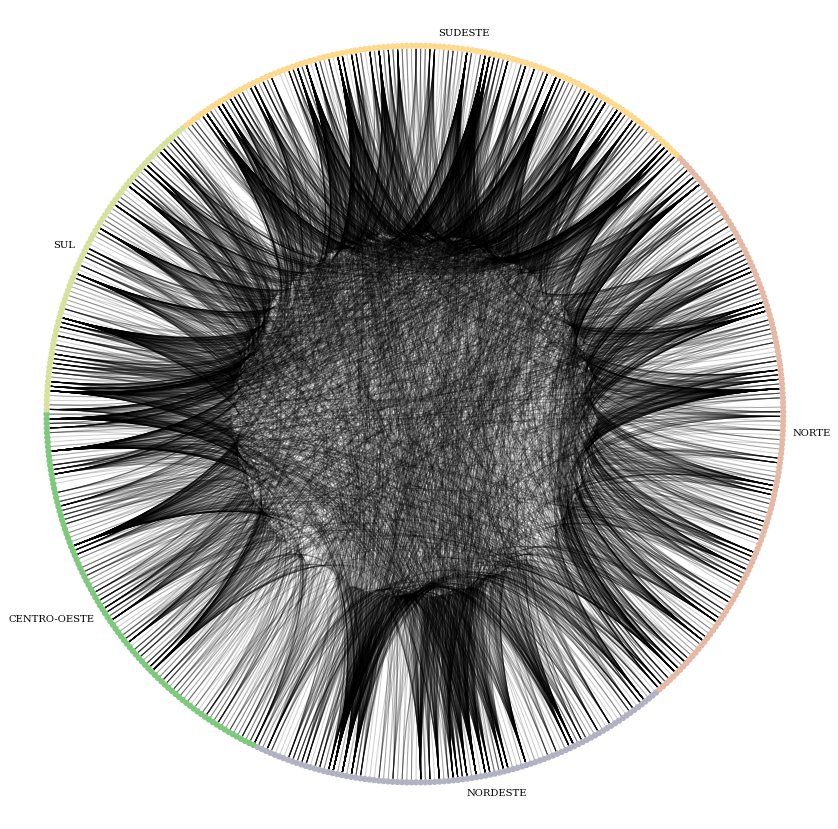

In [12]:
from nxviz import CircosPlot
circ = nxviz.CircosPlot(
    SG,
    node_grouping = "region",
    node_color = "region",
    group_label_position = "middle",
    figsize=(15,15)
)
circ.draw()
plt.savefig("images/assortativity.png")
plt.show()

When analyzing the graph, it is noticed that the regions tend to connect with themselves, especially the Southeast region, but it's not a perfect associative network as nodes from different regions connect.

<br /> 

<br />

**Realizar uma análise bivariada entre o grau do vértice e o número médio de vizinhos.**

**● Gerar um gráfico considerando a rede do Brasil e de todas as Regiões (Norte, Nordeste, Sul, Sudeste e Centro-Oeste).**

**● Fazer um relato dos principais achados.**

Bivariate analysis is one of the forms of quantitative (statistical) analysis.It involves the analysis of two variables, for the purpose of determining the empirical relationship between them.

In [13]:
average_neighbor_degree_list = list(nx.average_neighbor_degree(SG).values())

degrees_list = list({node: val for (node, val) in SG.degree()}.values())

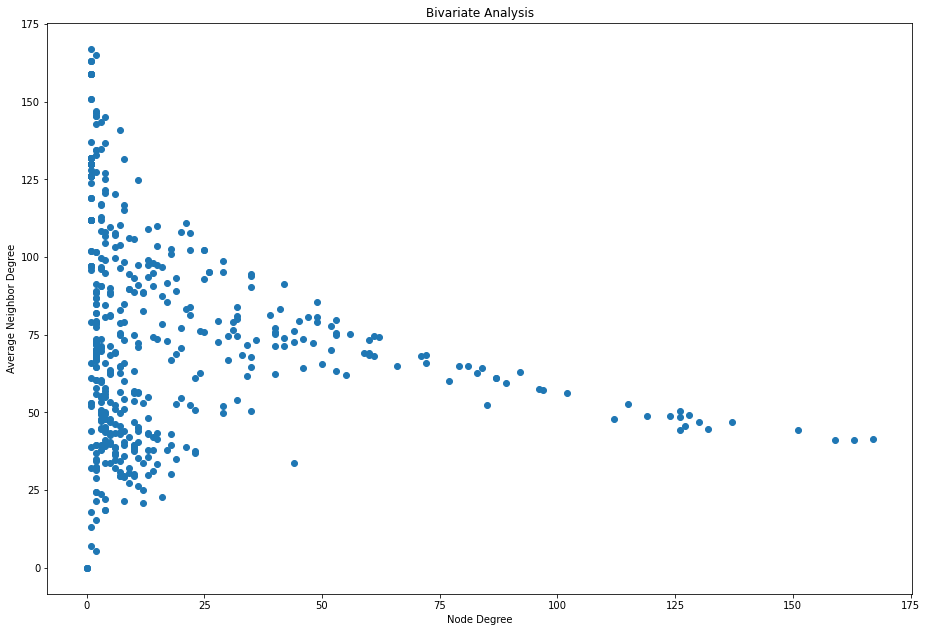

In [14]:
df = pd.DataFrame({'degrees': degrees_list,
                   'average_neighbor_degree': average_neighbor_degree_list})
plt.scatter(df.degrees, df.average_neighbor_degree)
plt.title('Bivariate Analysis')
plt.xlabel('Node Degree')
plt.ylabel('Average Neighbor Degree')
fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
plt.savefig("images/bivariate_analysis.png")

<br />

<br />

**● Quantos componentes conectados existem na malha aérea
brasileira?**

*   **Caracterize cada componente: quantidade, porcentagem por região**

Check if the network is connected:

In [15]:
nx.is_connected(SG)

False

In [16]:
for component in list(nx.connected_components(SG)):
    print(len(component))

491
1
1
1
1


The network has five components, a component is an induced subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the rest of the graph

In [17]:
for component in list(nx.connected_components(SG)):
    print(component)

{'SNJD', 'SWNS', 'SBCY', 'SSAB', 'SWGI', 'SBAC', 'SBJI', 'SIXE', 'SBAN', 'SSUM', 'SWLC', 'SBKG', 'SWBR', 'SNAT', 'SWKC', 'SBUR', 'SJQP', 'SWHT', 'SWZM', 'SNZR', 'SNBU', 'SBML', 'SBUG', 'SSCK', 'SJRG', 'SNDQ', 'SNSM', 'SNOB', 'SBGR', 'SBSN', 'SBBZ', 'SWJI', 'SNLA', 'SNOS', 'SNCT', 'SWFE', 'SNUB', 'SBCV', 'SWPI', 'SWUY', 'SDPA', 'SBCX', 'SDUN', 'SNTS', 'SNRJ', 'SBAG', 'SBPF', 'SNDM', 'SNBA', 'SBMK', 'SBAM', 'SNKI', 'SSHZ', 'SNVB', 'SWSQ', 'SBBR', 'SWJV', 'SNJR', 'SWEU', 'SIRI', 'SSBG', 'SDCO', 'SBUL', 'SBLN', 'SBMQ', 'SBTL', 'SDAA', 'SBYS', 'SBGL', 'SNKK', 'SNMH', 'SNXL', 'SNPP', 'SNQD', 'SBAA', 'SBJU', 'SWCQ', 'SWEE', 'SILJ', 'SBCP', 'SBBV', 'SWKO', 'SWBI', 'SBSV', 'SBCA', 'SNKB', 'SNYA', 'SBRF', 'SNCI', 'SNMX', 'SNVV', 'SWFN', 'SBCB', 'SBMO', 'SBMC', 'SWOB', 'SBBW', 'SWRD', 'SWBU', '2NHT', 'SNQW', 'SWWU', 'SBVC', 'SBJF', 'SNYV', 'SNVR', 'SDMC', 'SWQR', 'SNSG', 'SBJV', 'SSVL', 'SDZG', 'SNBM', 'SJUR', 'SBTT', 'SBDB', 'SSLT', 'SSUW', 'SNIC', 'SDOW', 'SNNU', 'SBPN', 'SBJA', 'SNAR', 'SBIT',

The giant component has 497 connected airports and the others 4 components are individual nodes.

Percentage of nodes by region in the giant component:

In [18]:
from collections import Counter

percentage_by_region = []
for node, data in SG.nodes(data=True):
  if node in nx.node_connected_component(G, "SDUB"):
    percentage_by_region.append(data['region'])

count = dict(Counter(percentage_by_region))
count.update((x, (y*100)/497) for x, y in count.items())
count

{'NORDESTE': 18.51106639839034,
 'CENTRO-OESTE': 17.907444668008047,
 'SUL': 14.084507042253522,
 'NORTE': 25.75452716297787,
 'SUDESTE': 23.34004024144869}

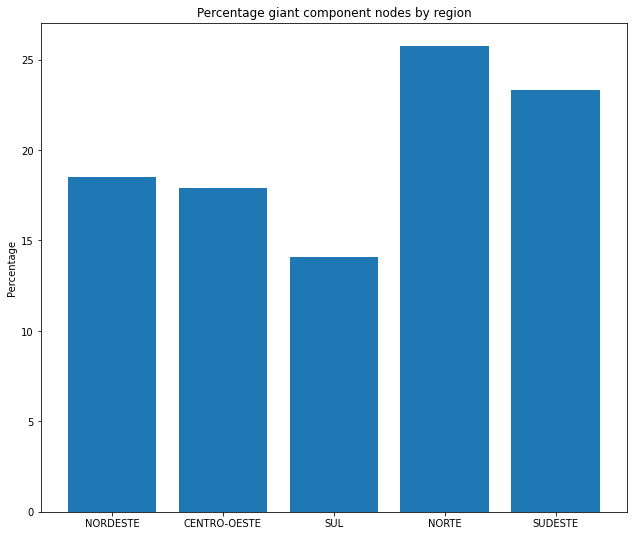

In [19]:
keys = count.keys()
values = count.values()

plt.bar(keys, values)
plt.title('Percentage giant component nodes by region')
plt.ylabel('Percentage')
fig = plt.gcf()
fig.set_size_inches(10.5, 9)
plt.savefig("images/percentage_nodes_by_region.png")

<br />

<br />

**● Crie um cenário simulado, onde se deseja fazer uma viagem com o seguinte trajeto:**

*   **cidade 1 (Norte) para cidade 2 (Sul)**
*   **cidade 2 (Sul) para cidade 3 (Nordeste)**
*   **cidade 3 (Nordeste) para cidade 4 (Centro-Oeste)**
*   **cidade 4 (Centro-Oeste) para cidade 5 (Sudeste)**

**Utilizando o conceito do caminho mais curto, descreva o caminho percorrido e a
quantidade de trajetos realizados.**

Traveling from SBBV (Boa Vista - Roraima) to SBFL (Florianópolis - Santa Catarina)

In [20]:
nx.shortest_path(SG,source='SBBV',target='SBFL')

['SBBV', 'SBFL']

Traveling from SBFL (Florianópolis - Santa Catarina) to SBFZ (Fortaleza - Ceará) 

In [21]:
nx.shortest_path(SG,source='SBFL',target='SBFZ')

['SBFL', 'SBFZ']

Traveling from SBFZ (Fortaleza - Ceará) to SBGO (Goiânia - Goiás):

In [22]:
nx.shortest_path(SG,source='SBFZ',target='SBGO')

['SBFZ', 'SBGO']

Traveling from SBGO (Goiânia - Goiás) to SBRJ (Rio de Janeiro)

In [23]:
nx.shortest_path(SG,source='SBGO',target='SBRJ')

['SBGO', 'SBRJ']

Using the scenario, the number of paths covered was only one in each path since the nodes are connected.